# Lab 3 Mathieu Rundstrom

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. We determine the constant $C$ in the assumed dependence $||L_n|| = C\log n$.

In [2]:
#Returns num Chebyshev nodes
def getChebyshevNodes(num):
    k = np.arange(num)+1
    return np.cos((2*k-1)/(2*num)*np.pi)

def getLagrangeBasis(k, x, nodes):
    nodes = np.reshape(nodes,(nodes.shape[0],1))
    N = nodes.shape[0]
    X = np.tile(x,[N-1,1])
    idx = np.arange(N)
    return np.prod(np.tile(x,[N-1,1])-nodes[idx!=k],0)/np.prod(np.tile(nodes[k],[N-1,1])-nodes[idx!=k],0)
    
def lambdFct(x,N,nodes):
    LamSum = 0
    for k in range(0,N):
        LamSum += np.abs(getLagrangeBasis(k,x,nodes))
    return LamSum

In [3]:
max_N = 200
lamb = np.zeros(max_N-1)
for N in range(1,max_N):
    nodes = getChebyshevNodes(N)
    lamb[N-1] = lambdFct(-1,N,nodes)

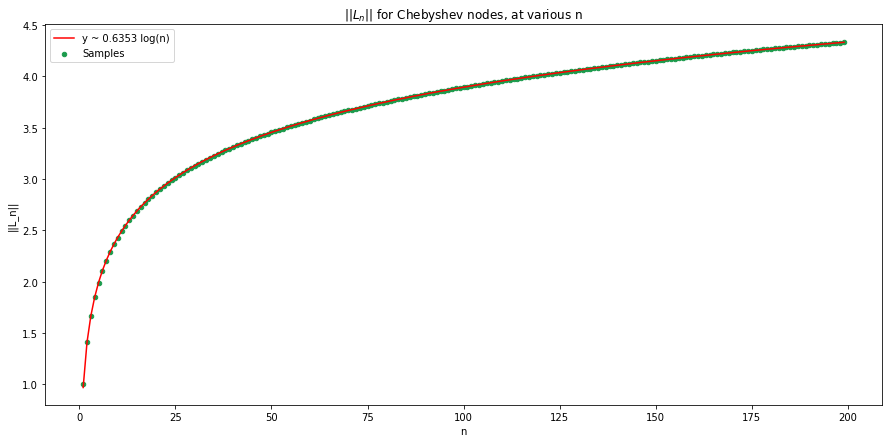

In [4]:
fig = plt.figure(figsize=(15,7))
plt.scatter(range(1,max_N),lamb, s=20, c = '#1b9b4c')

X = range(1,max_N)
X_log = np.log(X)
A = np.vstack([X_log, np.ones(len(X_log))]).T
C, y_int = np.linalg.lstsq(A, lamb)[0]
plt.plot(X,C*X_log+y_int,'-r')

plt.title(r'$\||L_n\||$ for Chebyshev nodes, at various n')
plt.ylabel('||L_n||')
plt.xlabel('n')
    
plt.legend(['y ~ %.4f log(n)' %(C,), 'Samples'])
plt.show()

We see from above that $C\approx 0.6353$. 

## 2. For interpolation with equidistant nodes, we find the relation $||L_n|| \sim 2^n$

First, we find the derivative of $\lambda_n$

\begin{align*}
\lambda_n &= \sum_{k=0}^n |\phi_{n, k}(x)|\\
&= \sum_{k=0}^n \big[(\phi_{n,k}(x)^2 \big]^{1/2}
\end{align*}

Hence

\begin{align*}
\lambda_n' &= \sum_{k=0}^n\frac{1}{2}(\phi_{n,k}(x)^2)^{-1/2}2\phi_{n,k}(x)\phi'_{n,k}(x)\\
&= \sum_{k=0}^n \frac{\phi_{n,k}(x)}{|\phi_{n,k}(x)|}\phi'_{n,k}(x)
\end{align*}

where

$$
\phi'_{n,k} = \phi_{n,k}\sum_{i=0,i\ne k}^n\frac{1}{x_k-x_i} =  \sum_{i=0,i\ne k}^n\frac{1}{x_k-x_i}\prod_{m=0,m\ne i,k}^n\frac{x-x_m}{x_k-x_m}
$$

We use the secant method to avoid computing the second derivative, the first is already ugly enough.We look at the maximum in the rightmost interval.

In [46]:
def getLagrangeBasisDeriv(x,nodes,k):
    nodes = np.reshape(nodes,(nodes.shape[0],1))
    N = nodes.shape[0]
    X = np.tile(x,[N-1,1])
    
    idx = np.arange(N) 
    SUM = 0
    for i in range(0,N):
        if(i != k):
            SUM += 1/(nodes[k]-nodes[i])*np.prod(np.tile(x,[N-2,1])-nodes[np.logical_and(idx!=k,idx!=i)],0)/np.prod(np.tile(nodes[k],[N-2,1])-nodes[np.logical_and(idx!=k,idx!=i)],0)
    return SUM

def lambdDeriv(x,N,nodes):
    LamSum = 0
    for k in range(0,N):
        L = getLagrangeBasis( k, x, nodes)
        L[L==0] = 1e-8
        LamSum += L*getLagrangeBasisDeriv(x,nodes,k)/abs(L)
    return LamSum

def SecantMethod(x,y,f):
    if(abs(f(x)) < 1e-8):
        return x
    else:
        f_dif = (f(x)-f(y))/(x-y)
        return SecantMethod(x-f(x)/f_dif,x,f)

In [49]:
N0 = 5
N_max = 20
L = np.zeros(N_max-N0)
for N in range(N0,N_max):
    nodes = np.linspace(-1,1,N)
    g = lambda x: lambdDiff(x,N,nodes)
    x0 = (nodes[0]+nodes[1])/2
    x1 = (2*nodes[0]+nodes[1])/3
    r = SecantMethod(x0,x1,g)
    L[N-N0] = lambdFct(r,N,nodes)

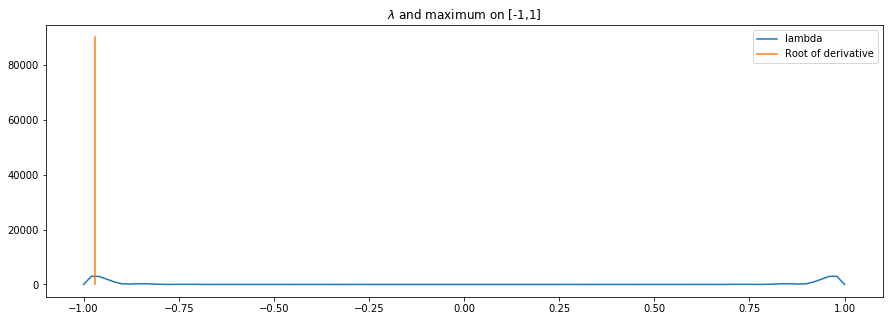

ValueError: unsupported format character '^' (0x5e) at index 6

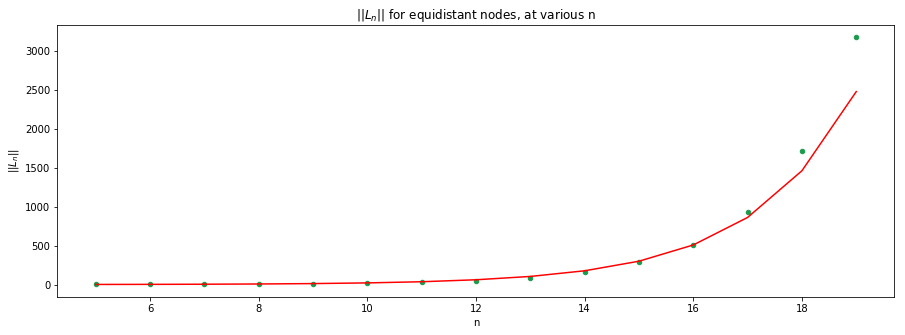

In [50]:
fig = plt.figure(figsize=(15,5))
plt.title(r'$\lambda$ and maximum on [-1,1]')
plt.plot(np.linspace(-1,1,100),lambdFct(np.linspace(-1,1,100),N,nodes))
plt.plot([r,r],[0,90000])
plt.legend(['lambda','Root of derivative'])
plt.show()


fig = plt.figure(figsize=(15,5))
plt.scatter(range(N0,N_max),L,s=20, c = '#1b9b4c')

X = range(N0,N_max)
A = np.vstack([X, np.ones(len(X))]).T
C, y_int = np.linalg.lstsq(A, np.log(L)/np.log(2))[0]
plt.title(r'$\||L_n\||$ for equidistant nodes, at various n')
plt.plot(X,2**(C*X+y_int),'-r')

plt.ylabel(r'$||L_n||$')
plt.xlabel('n')
    
plt.legend(['y = %2^(%.4f n)' %C, 'Samples'])

plt.show()


From the first graph, we see that we indeed found the maxiumum in the last interval. From the second graph, we see that $||L_n||$ fits an exponential in $n$.

## 3. We seek 
$$ ||S_n|| = \int _0^\pi \left | \frac{ \sin ((n+1/2)\theta) }{ 2 \sin (1/2\theta) } \right |$$

In [31]:
def Kernel(n, theta):
    theta[theta == 0] = 1e-8
    return np.sin((n+1/2)*theta)/(2*np.sin(1/2*theta))

def tIntegration(f,nodes):
    S = 0
    for i in range(0,len(nodes)-1):
        S += np.abs(nodes[i+1]-nodes[i])*(f(nodes[i+1])+f(nodes[i]))/2
    return S

In [32]:
N_max = 150
N0 = 1
S = np.zeros(N_max-N0)
for N in range(N0,N_max):
    f = lambda x: abs(Kernel(N,np.array(x)))
    nodes = (np.arange(N))*np.pi/(N+0.5)
    nodes = np.append(nodes,np.pi)
    for i in range(0,len(nodes)-1):
        S[N-N0] += tIntegration(f,np.linspace(nodes[i],nodes[i+1],100))

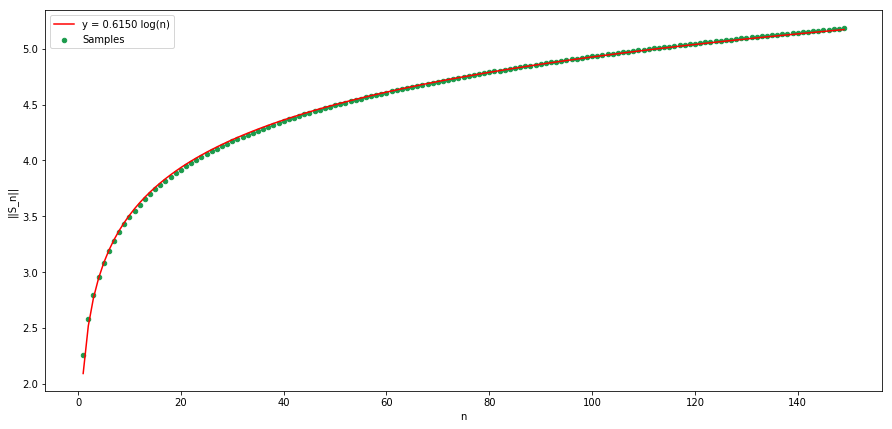

In [33]:
fig = plt.figure(figsize=(15,7))
plt.scatter(range(N0,N_max),S, s=20, c = '#1b9b4c')

X = range(N0,N_max)
X_log = np.log(X)
A = np.vstack([X_log, np.ones(len(X_log))]).T
C, y_int = np.linalg.lstsq(A, S)[0]
plt.plot(X,C*X_log+y_int,'-r')

plt.ylabel('||S_n||')
plt.xlabel('n')
    
plt.legend(['y = %.4f log(n)' %C, 'Samples'])


plt.show()

Fitting our samples with a log function we find that $C\approx0.6150$.

## 4. We seek 

$$\int_{-1}^{1} \left | \sum_{k=0}^n a_k P_k(x) \right | $$ 

where $P_k(x)$ is the kth Legendre polynomial.

In [11]:
def sumFunc(x,n):
    S = 0
    for k in range(0,n+1):
        # Get kth Legendre polynomial
        f = np.polynomial.legendre.Legendre.basis(k)
        S += (a_k(k)*f(x))
    return abs(S)

def a_k(k):
    return k+0.5

In [35]:
N_max = 60
N0 = 0
nodes = [-1,1]
S2 = np.zeros(N_max-N0)
r = []
for N in range(N0,N_max):
    nodes = np.append(r,np.polynomial.legendre.Legendre.basis(N).roots())
    nodes = np.sort(nodes)
    for i in range(0,len(nodes)-1):
        S2[N-N0] += tIntegration(lambda x: sumFunc(x,N),np.linspace(nodes[i],nodes[i+1],10))

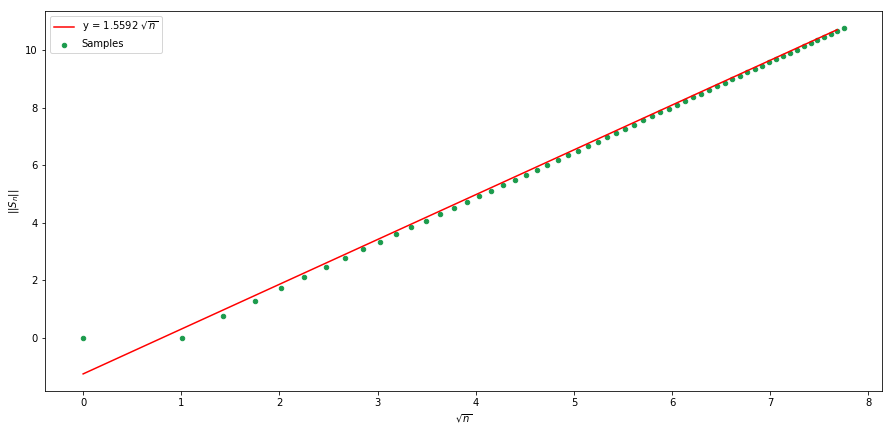

In [43]:
fig = plt.figure(figsize=(15,7))
plt.scatter(np.linspace(N0,N_max,N_max-N0)**0.5,S2, s=20, c = '#1b9b4c')

X = range(N0,N_max)
X_sqrt = np.sqrt(X)
A = np.vstack([X_sqrt, np.ones(len(X_sqrt))]).T
C, y_int = np.linalg.lstsq(A, S2)[0]
plt.plot(X_sqrt,C*X_sqrt+y_int,'-r')

plt.ylabel(r'$||S_n||$')
plt.xlabel(r'$\sqrt{n}$')
    
plt.legend([r'y = %.4f $\sqrt{n}$' %C, 'Samples'])


plt.show()

Fitting our samples with a square roots function we find that $C\approx 1.5592$.Note that the $x$-axis is the square root of $n$.

# 5. Finally, we seek 
$$ || Q_n || = \sum_{k=0}^n \left | \int_a^b \phi _{n,k} \right | $$
where $\phi_{n,k}$ is the k-th Lagrange basis function assoiated to the nodes $x_0,...,x_n$. We apply the quadrature approach.

In [17]:
N_max = 60
N0 = 1
Q = np.zeros(N_max-N0)
for N in range(N0,N_max):
    nodes = np.linspace(0,1,N+1)
    for k in range(0,N+1):
        I = 0
        for i in range(0,len(nodes)-1):
            I += tIntegration(lambda x: getLagrangeBasis(k, x, nodes),np.linspace(nodes[i],nodes[i+1],10))
        Q[N-N0] += abs(I)

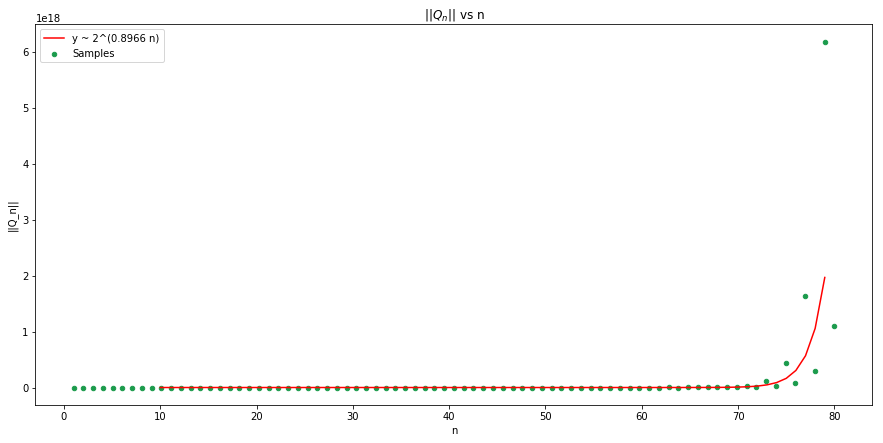

In [19]:
fig = plt.figure(figsize=(15,7))
plt.scatter(np.linspace(N0,N_max,N_max-N0),Q, s=20, c = '#1b9b4c')

X = range(10,N_max)
A = np.vstack([X, np.ones(len(X))]).T
C, y_int = np.linalg.lstsq(A, np.log(Q[9:])/np.log(2))[0]
plt.title(r'$\||Q_n\||$ vs n')

plt.plot(X,2**(C*X+y_int),'-r')

plt.ylabel(r'$||Q_n||$')
plt.xlabel('n')
    
plt.legend(['y ~ 2^(%.4f n)' %(C), 'Samples'])

plt.show()

This clearly suggests that the relation between $||Q_n||$ and $n$ is an exponential one.